In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import copy

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/ML Data/fashion-mnist_train.csv').iloc[:18000,:]
test_df = pd.read_csv('/content/drive/MyDrive/ML Data/fashion-mnist_test.csv').iloc[:2000,:]
data=pd.concat([train_df,test_df],axis=0)

dataset = data.to_numpy()

from sklearn.preprocessing import StandardScaler
rows=dataset.shape[0]

X_train,y_train = dataset[:int(0.8*rows), 1:]/255, dataset[:int(0.8*rows),0]
X_val,y_val= dataset[int(0.8*rows):int(0.9*rows), 1:]/255, dataset[int(0.8*rows):int(0.9*rows), 0]
X_test,y_test= dataset[int(0.9*rows): , 1:]/255, dataset[int(0.9*rows): , 0]

standardscalar = StandardScaler()
X_train = standardscalar.fit_transform(X_train)
X_val= standardscalar.transform(X_val)
X_test = standardscalar.transform(X_test)

In [5]:
print(X_train.shape,X_test.shape,X_val.shape,y_val.shape,y_train.shape,y_test.shape)

(16000, 784) (2000, 784) (2000, 784) (2000,) (16000,) (2000,)


In [6]:


from sklearn.preprocessing import LabelBinarizer
class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
      if activation not in self.acti_fns:
          raise Exception('Incorrect Activation Function')

      if weight_init not in self.weight_inits:
          raise Exception('Incorrect Weight Initialization Function')
      self.n_layers=n_layers
      print("layers=",self.n_layers)
      self.layer_sizes=layer_sizes
      print("layers sizes=",self.layer_sizes)
      self.activation=activation
      print("Act fn=",self.activation)
      self.learning_rate=learning_rate
      print("learnign rate=",self.learning_rate)
      self.weight_init=weight_init
      print("weight init=",self.weight_init)
      self.batch_size=batch_size
      print("batch size=",self.batch_size)
      self.num_epochs=num_epochs
      print("epochs=",self.num_epochs)

    #initiate inital weights and biases matrices for all layers
    def init_params(self):
      i=0
      networkVariables={}
      while i in range(0,self.n_layers):
        if self.weight_init=='random':
          w=self.random_init((self.layer_sizes[i],self.layer_sizes[i+1]))
          b=np.zeros((1,self.layer_sizes[i+1]))
        
        elif self.weight_init=='normal':
          w=self.normal_init((self.layer_sizes[i],self.layer_sizes[i+1]))
          b=np.zeros((1,self.layer_sizes[i+1]))

        elif self.weight_init=='zero':
          w=self.zero_init((self.layer_sizes[i],self.layer_sizes[i+1]))
          b=np.zeros((1,self.layer_sizes[i+1]))

        networkVariables["W"+str(i+1)]=w
        networkVariables["b"+str(i+1)]=b
        i=i+1
      return networkVariables

    def activation_fn(self,fn,x):
      if fn=="relu":
        return self.relu(x)
      elif fn=="sigmoid":
        return self.sigmoid(x)
      elif fn=="linear":
        return self.linear(x)
      elif fn=="tanh":
        return self.tanh(x)

    def activation_grad_fn(self,fn,x):
      if fn=="relu":
        return self.relu_grad(x)
      elif fn=="sigmoid":
        return self.sigmoid_grad(x)
      elif fn=="linear":
        return self.linear_grad(x)
      elif fn=="tanh":
        return self.tanh_grad(x)


    def compare_with_mlp(self,loss_from_your_model,X,y):
      # comparing with MLP
      # X is all data and Y is all labels
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

      mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='relu',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)

      mlp.fit(X_train, y_train)

      loss_from_sklearn = mlp.loss_curve_

      plt.plot(loss_from_sklearn,label="sklearn")
      plt.plot(loss_from_your_model,label="your NN")
      plt.legend(loc="upper left")
      plt.savefig("result.png")
      plt.close()

    def categorizer(self,y):
      lb=LabelBinarizer()
      return lb.fit_transform(y)
      

    def relu(self, X):
      return np.maximum(0,X)

    def relu_grad(self, X):
      z=X>=0
      z=np.dot(z,1)
      return z

    def sigmoid(self, X):
      return(1/(1 + np.exp(-X)))

    def sigmoid_grad(self, X):
      k=self.sigmoid(X)
      return k*(1-k)

    def linear(self, X):
      return X

    def linear_grad(self, X):
      return np.ones(X.shape)

    def tanh(self, X):
      return np.tanh(X)

    def tanh_grad(self, X):
      temp=self.tanh(X)
      return 1-(temp*temp)

    def softmax(self, X):
      ex = np.exp(X-np.max(X))
      return ex / np.sum(ex,axis=1,keepdims=True)

    def softmax_grad(self, X):
      der=self.softmax(X)
      return der*(1-der)

    def zero_init(self, shape):
      """
      Calculating the initial weights after Zero Activation for a particular layer

      Parameters
      ----------
      shape : tuple specifying the shape of the layer for which weights have to be generated 

      Returns
      -------
      weight : 2-dimensional numpy array which contains the initial weights for the requested layer
      """
      return np.zeros(shape)

    def random_init(self, shape):
      weights=np.random.rand(shape[0],shape[1])*0.01
      return weights

    def normal_init(self, shape):
      weights=np.random.normal(size=shape,scale=0.01)
      return weights
        
    def forward_prop(self,x,params):
      layers=self.n_layers 
      values={}
      for i in range(1,layers+1):
        if i==1:
          values["Z"+str(i)]= np.dot(x,params["W"+str(i)]) + params["b"+str(i)]
          values["A"+str(i)]=self.activation_fn(self.activation,values["Z"+str(i)])
        else:
          values["Z"+str(i)]= np.dot(values["A"+str(i-1)],params["W"+str(i)]) + params["b"+str(i)]
          if i==layers:
            print("Zo->",values["Z"+str(layers)])
            values['A' + str(i)] = self.softmax(values['Z' + str(i)])
          else:
            values["A"+str(i)]= self.activation_fn(self.activation,values["Z"+str(i)])
        # print("Z",i," shape->",values["Z"+str(i)].shape)
        # print("A",i," shape->",values["A"+str(i)].shape)
      y_prob=values["A"+str(layers)]      
      return values,y_prob

    def cross_entropy_loss(self,y_pred, y): #takes true values and dictionary having activations of all layers as input and returns cost
      noise = 1e-8
      loss=-np.sum(np.dot(y,np.log(y_pred+noise)))
      return loss/float(y_pred.shape[0])

    def back_prop(self,params,values,x,y):
      layers= len(values)//2
      m=len(y)
      # print("layers=",layers,",m=",m)
      grads={}
      for i in range(layers,0,-1):
        if i==layers:
          dz=(1/m)*(values["A"+str(i)]-y)
          print("dz-->",dz)
          print("------------------------------")
        else:
          dz= np.multiply(np.dot(params["W"+str(i+1)],dz.T).T,self.activation_grad_fn(self.activation,values["Z"+str(i)]))
        # print("dz shape ->",dz.shape)
        if i==1:
          grads["W"+str(i)]= np.dot(x.T,dz)
          grads["b"+str(i)]= np.sum(dz,axis = 0, keepdims = True)
        else:
          grads["W"+str(i)]= np.dot(values["A"+str(i-1)].T,dz)
          grads["b"+str(i)]= np.sum(dz,axis=0, keepdims = True)
      
        # print("gradW",i," shape->",grads["W"+str(i)].shape)
        # print("gradB",i," shape->",grads["b"+str(i)].shape)
      return grads

    def update_params(self,grads,params,learning_rate):
      layers=len(params)//2
      updated_params={}
      for i in range(1,layers+1):
        updated_params["W"+str(i)]=params["W"+str(i)]-learning_rate*grads["W"+str(i)]
        updated_params["b"+str(i)]=params["b"+str(i)]-learning_rate*grads["b"+str(i)]
        # print("updated_params shape W-> ",updated_params["W"+str(i)].shape)
        # print("updated_params shape b-> ",updated_params["b"+str(i)].shape)
      return updated_params




    def fit(self, X, y):
      # fit function has to return an instance of itself or else it won't work with test.py
      networkVariables=self.init_params()
      self.params=networkVariables
      total_batches=int(X.shape[0]/self.batch_size)
      y=self.categorizer(y)
      input_batch=[]
      label_batch=[]
      for index in range(0,total_batches):
        input_batch.append(X[self.batch_size*index:self.batch_size*(index+1),:])
        label_batch.append(y[self.batch_size*index:self.batch_size*(index+1),:])

      for iteration in range(0,self.num_epochs):
        batchLoss=[]
        for i,j in zip(input_batch,label_batch):
          #Forward pass
          values,y_prob=self.forward_prop(i,self.params)
          #Loss calculation
          loss=self.cross_entropy_loss(y_prob,j)
          print(y_prob)
          # print("---------------------------------------------------------> loss=",loss)
          if math.isnan(loss):
            batchLoss.append(0)
          else:
            batchLoss.append(loss)
          grads=self.back_prop(self.params,values,i,j)
          self.params= self.update_params(grads,self.params,self.learning_rate)
        print("loss for epoch=",iteration+1,": ",np.array(batchLoss).mean())  
      return self

    def predict_proba(self, X):
      """
      Predicting probabilities using the trained linear model.

      Parameters
      ----------
      X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

      Returns
      -------
      y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
          class wise prediction probabilities.
      """
      _, out_prob=self.forwardPropagation(X,self.params)
      return out_prob

    def predict(self, X):
      # return the numpy array y which contains the predicted values
      return np.argmax(self.predict_proba(X),axis=1)

    def score(self, X, y):
      ypred=self.predict(X)
      return (ypred==y).sum()/len(y)


In [7]:
model_relu = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'relu', 0.1, 'normal', len(X_train)//32, 100)
model_sigmoid = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', len(X_train)//32, 100)
model_linear = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', len(X_train)//32, 100)
model_tanh = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'tanh', 0.1, 'normal', len(X_train)//32, 100)

model_relu.fit(X_train,y_train,X_val,y_val)
model_sigmoid.fit(X_train,y_train,X_val,y_val)
model_linear.fit(X_train,y_train,X_val,y_val)
model_tanh.fit(X_train,y_train,X_val,y_val)


Epoch: 1 / 100  for  relu
Epoch: 2 / 100  for  relu
Epoch: 3 / 100  for  relu
Epoch: 4 / 100  for  relu
Epoch: 5 / 100  for  relu
Epoch: 6 / 100  for  relu
Epoch: 7 / 100  for  relu
Epoch: 8 / 100  for  relu
Epoch: 9 / 100  for  relu
Epoch: 10 / 100  for  relu
Epoch: 11 / 100  for  relu
Epoch: 12 / 100  for  relu
Epoch: 13 / 100  for  relu
Epoch: 14 / 100  for  relu
Epoch: 15 / 100  for  relu
Epoch: 16 / 100  for  relu
Epoch: 17 / 100  for  relu
Epoch: 18 / 100  for  relu
Epoch: 19 / 100  for  relu
Epoch: 20 / 100  for  relu
Epoch: 21 / 100  for  relu
Epoch: 22 / 100  for  relu
Epoch: 23 / 100  for  relu
Epoch: 24 / 100  for  relu
Epoch: 25 / 100  for  relu
Epoch: 26 / 100  for  relu
Epoch: 27 / 100  for  relu
Epoch: 28 / 100  for  relu
Epoch: 29 / 100  for  relu
Epoch: 30 / 100  for  relu
Epoch: 31 / 100  for  relu
Epoch: 32 / 100  for  relu
Epoch: 33 / 100  for  relu
Epoch: 34 / 100  for  relu
Epoch: 35 / 100  for  relu
Epoch: 36 / 100  for  relu
Epoch: 37 / 100  for  relu
Epoch: 38 

In [9]:
model_sigmoid1=model_tanh

Q1. 5. b)

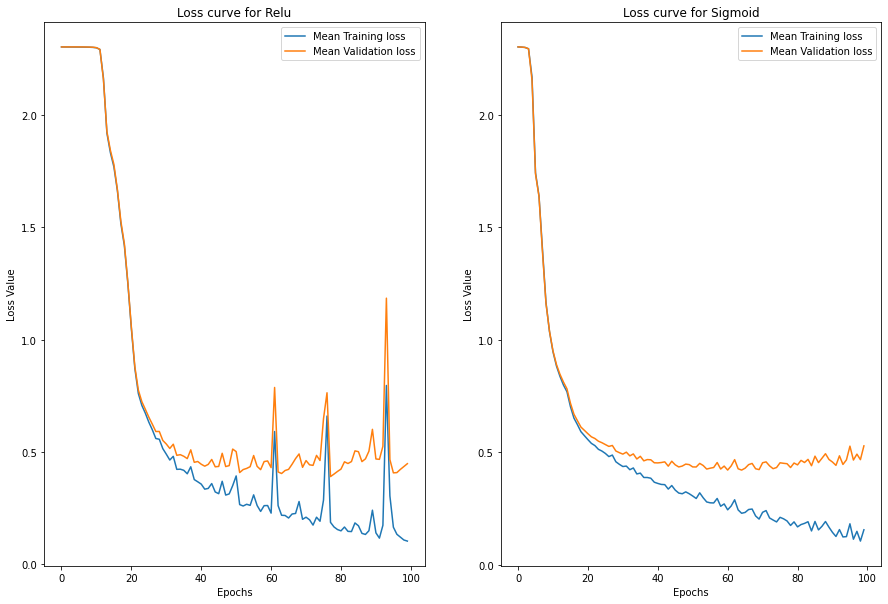

In [10]:
def drawplot(model,function_name):
  plt.plot([i for i in range(model.num_epochs)],model.train_loss_history,label='Mean Training loss')
  plt.plot([i for i in range(model.num_epochs)],model.test_loss_history,label='Mean Validation loss')
  plt.title(f'Loss curve for {function_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss Value')
  plt.legend()


#Draw plot
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
drawplot(model_relu,"Relu")

plt.subplot(1,2,2)
drawplot(model_sigmoid1,"Sigmoid")
plt.show()




Q1. 5. c)

In [24]:
def get_filename(function,iteration):
  return str(iteration)+"_"+function+"_model.pkl"

model_relu_50_loaded= pickle.load(open(get_filename("relu",50), 'rb'))
print("Accuracy for relu after 50 iterations: ",model_relu_50_loaded.score(X_test,y_test))
model_relu_100_loaded= pickle.load(open(get_filename("relu",100), 'rb'))
print("Accuracy for relu after 100 iterations: ",model_relu_100_loaded.score(X_test,y_test))
print("-"*30)

model_sigmoid_50_loaded= pickle.load(open(get_filename("sigmoid",50), 'rb'))
print("Accuracy for sigmoid after 50 iterations: ",model_sigmoid_50_loaded.score(X_test,y_test))
model_sigmoid_100_loaded= pickle.load(open(get_filename("sigmoid",100), 'rb'))
print("Accuracy for sigmoid after 100 iterations: ",model_sigmoid_100_loaded.score(X_test,y_test))
print("-"*30)


model_linear_50_loaded= pickle.load(open(get_filename("linear",50), 'rb'))
print("Accuracy for linear after 50 iterations: ",model_linear_50_loaded.score(X_test,y_test))
model_linear_100_loaded= pickle.load(open(get_filename("linear",100), 'rb'))
print("Accuracy for linear after 100 iterations: ",model_linear_100_loaded.score(X_test,y_test))
print("-"*30)

model_tanh_50_loaded= pickle.load(open(get_filename("tanh",50), 'rb'))
print("Accuracy for tanh after 50 iterations: ",model_tanh_50_loaded.score(X_test,y_test))
model_tanh_100_loaded= pickle.load(open(get_filename("tanh",100), 'rb'))
print("Accuracy for tanh after 100 iterations: ",model_tanh_100_loaded.score(X_test,y_test))
print("-"*30)

Accuracy for relu after 50 iterations:  0.659
Accuracy for relu after 100 iterations:  0.8565
------------------------------
Accuracy for sigmoid after 50 iterations:  0.0975
Accuracy for sigmoid after 100 iterations:  0.0975
------------------------------
Accuracy for linear after 50 iterations:  0.818
Accuracy for linear after 100 iterations:  0.817
------------------------------
Accuracy for tanh after 50 iterations:  0.8095
Accuracy for tanh after 100 iterations:  0.799
------------------------------


Q1.6)

In [18]:
def compare_with_mlp(model,X,y):
  # comparing with MLP
  # X is all data and Y is all labels
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  if model.activation=='linear':
    act_fn='identity'
  elif model.activation=='sigmoid':
    act_fn='logistic'
  else:
    act_fn=model.activation
    
  loss= model_relu.train_loss_history
  mlp50= MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation =act_fn, solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True, momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
  mlp100 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation =act_fn, solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True, momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
  mlp50.fit(X, y)
  mlp100.fit(X, y)

  filename=str(50)+"_mlp_"+model.activation+".pkl"
  pickle.dump(mlp50,open(filename,"wb"))
  filename=str(100)+"_mlp_"+model.activation+".pkl"
  pickle.dump(mlp100,open(filename,"wb"))

  loss_from_sklearn = mlp100.loss_curve_
  plt.plot(loss_from_sklearn,label="sklearn")
  plt.plot(model.train_loss_history,label="your NN")
  plt.legend(loc="upper left")
  plt.savefig("compare_mlp_result_"+model.activation+".png")
  plt.close()


compare_with_mlp(model_relu,X_train,y_train)
compare_with_mlp(model_sigmoid,X_train,y_train)
compare_with_mlp(model_linear,X_train,y_train)
compare_with_mlp(model_tanh,X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multila

In [23]:
def get_filename_mlp(function,iteration):
  return str(iteration)+"_mlp_"+function+".pkl"

mlp_relu_50_loaded= pickle.load(open(get_filename_mlp("relu",50), 'rb'))
print("Accuracy of sklearn MLP for relu after 50 iterations: ",mlp_relu_50_loaded.score(X_test,y_test))
model_relu_50_loaded= pickle.load(open(get_filename("relu",50), 'rb'))
print("Accuracy for relu after 50 iterations: ",model_relu_50_loaded.score(X_test,y_test))
mlp_relu_100_loaded= pickle.load(open(get_filename_mlp("relu",100), 'rb'))
print("Accuracy of sklearn MLP for relu after 100 iterations: ",mlp_relu_100_loaded.score(X_test,y_test))
model_relu_100_loaded= pickle.load(open(get_filename("relu",100), 'rb'))
print("Accuracy for relu after 100 iterations: ",model_relu_100_loaded.score(X_test,y_test))
print("-"*30)


mlp_sigmoid_50_loaded= pickle.load(open(get_filename_mlp("sigmoid",50), 'rb'))
print("Accuracy of sklearn MLP for sigmoid after 50 iterations: ",mlp_sigmoid_50_loaded.score(X_test,y_test))
model_sigmoid_50_loaded= pickle.load(open(get_filename("sigmoid",50), 'rb'))
print("Accuracy for sigmoid after 50 iterations: ",model_sigmoid_50_loaded.score(X_test,y_test))
mlp_sigmoid_100_loaded= pickle.load(open(get_filename_mlp("sigmoid",100), 'rb'))
print("Accuracy of sklearn MLP for sigmoid after 100 iterations: ",mlp_sigmoid_100_loaded.score(X_test,y_test))
model_sigmoid_100_loaded= pickle.load(open(get_filename("sigmoid",100), 'rb'))
print("Accuracy for sigmoid after 100 iterations: ",model_sigmoid_100_loaded.score(X_test,y_test))
print("-"*30)


mlp_linear_50_loaded= pickle.load(open(get_filename("linear",50), 'rb'))
print("Accuracy of sklearn MLP for linear after 50 iterations: ",mlp_linear_50_loaded.score(X_test,y_test))
model_linear_50_loaded= pickle.load(open(get_filename("linear",50), 'rb'))
print("Accuracy for linear after 50 iterations: ",model_linear_50_loaded.score(X_test,y_test))
mlp_linear_100_loaded= pickle.load(open(get_filename_mlp("linear",100), 'rb'))
print("Accuracy of sklearn MLP for linear after 100 iterations: ",mlp_linear_100_loaded.score(X_test,y_test))
model_linear_100_loaded= pickle.load(open(get_filename("linear",100), 'rb'))
print("Accuracy for linear after 100 iterations: ",model_linear_100_loaded.score(X_test,y_test))
print("-"*30)


mlp_tanh_50_loaded= pickle.load(open(get_filename_mlp("tanh",50), 'rb'))
print("Accuracy of sklearn MLP for tanh after 50 iterations: ",mlp_tanh_50_loaded.score(X_test,y_test))
model_tanh_50_loaded= pickle.load(open(get_filename("tanh",50), 'rb'))
print("Accuracy for tanh after 50 iterations: ",model_tanh_50_loaded.score(X_test,y_test))
mlp_tanh_100_loaded= pickle.load(open(get_filename_mlp("tanh",100), 'rb'))
print("Accuracy of sklearn MLP for tanh after 100 iterations: ",mlp_tanh_100_loaded.score(X_test,y_test))
model_tanh_100_loaded= pickle.load(open(get_filename("tanh",100), 'rb'))
print("Accuracy for tanh after 100 iterations: ",model_tanh_100_loaded.score(X_test,y_test))
print("-"*30)














Accuracy of sklearn MLP for relu after 50 iterations:  0.8455
Accuracy for relu after 50 iterations:  0.659
Accuracy of sklearn MLP for relu after 100 iterations:  0.861
Accuracy for relu after 100 iterations:  0.8565
------------------------------
Accuracy of sklearn MLP for sigmoid after 50 iterations:  0.311
Accuracy for sigmoid after 50 iterations:  0.0975
Accuracy of sklearn MLP for sigmoid after 100 iterations:  0.3825
Accuracy for sigmoid after 100 iterations:  0.0975
------------------------------
Accuracy of sklearn MLP for linear after 50 iterations:  0.818
Accuracy for linear after 50 iterations:  0.818
Accuracy of sklearn MLP for linear after 100 iterations:  0.837
Accuracy for linear after 100 iterations:  0.817
------------------------------
Accuracy of sklearn MLP for tanh after 50 iterations:  0.8535
Accuracy for tanh after 50 iterations:  0.8095
Accuracy of sklearn MLP for tanh after 100 iterations:  0.857
Accuracy for tanh after 100 iterations:  0.799
----------------